In [40]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPool1D, Flatten, Dense, Average, Concatenate, Reshape, GlobalAveragePooling1D, Add
from tensorflow.keras import Input, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau

>  /content/drive/MyDrive/aifor cs/project/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv

>  /content/drive/MyDrive/aifor cs/project/Wednesday-workingHours.pcap_ISCX.csv






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Friday = pd.read_csv("/content/drive/MyDrive/aifor cs/project/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv") 
Friday.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
Wednesday = pd.read_csv("/content/drive/MyDrive/aifor cs/project/Wednesday-workingHours.pcap_ISCX.csv") 
Wednesday.head(5)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,6,6,6.000000,0.000000,3.132505e+02,52.208416,38308.000000,0.000000,38308,38308,0,0.000000,0.000000,0,0,0,0.000000,0.000000,0,0,0,0,0,0,20,20,26.104208,26.104208,6,6,6.000000,0.000000,0.000000,0,0,0,0,1,1,0,0,1,9.000000,6.000000,6.000000,20,0,0,0,0,0,0,1,6,1,6,255,946,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,163,0,65.200000,89.278777,1.039666e+06,33402.922760,31.933333,25.510409,73,0,479,47.900000,38.942836,109,1,401,100.250000,101.736178,237,3,0,0,0,0,368,176,22964.509390,10438.413360,0,163,29.294118,56.529599,3195.595588,0,0,0,1,0,0,0,0,0,31.125000,15.636364,65.200000,368,0,0,0,0,0,0,11,172,5,326,29200,260,4,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,1575,0,525.000000,813.326503,5.753425e+06,14611.872150,73.000000,204.960972,810,1,1095,121.666667,298.746130,915,1,995,199.000000,345.535092,810,3,0,0,0,0,336,208,9132.420091,5479.452055,0,1575,370.588235,671.751541,451250.132400,0,0,0,1,0,0,0,0,0,393.750000,315.000000,525.000000,336,0,0,0,0,0,0,10,3150,6,3150,29200,2081,3,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058824,425.778474,3069,0,555.000000,977.480342,6.650007e+05,1907.141918,543.071429,2519.931377,13391,0,15206,950.375000,3322.417812,13391,2,15112,1373.818182,4176.449588,13961,3,0,0,0,0,560,388,1117.979745,789.162173,0,3069,337.066667,704.654082,496537.374700,0,0,0,1,0,0,0,0,0,348.689655,203.058824,555.000000,560,0,0,0,0,0,0,17,3452,12,6660,29200,0,10,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,1576,0,525.333333,813.842901,5.771062e+06,13736.263740,78.000000,207.000929,794,1,1092,136.500000,313.850738,910,1,1015,203.000000,333.240154,794,3,0,0,0,0,304,208,8241.758242,5494.505495,0,1576,393.875000,704.585067,496440.116700,0,0,0,1,0,0,0,0,0,420.133333,350.000000,525.333333,304,0,0,0,0,0,0,9,3150,6,3152,29200,2081,2,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
#Modify names of columns
#--------friday dataset-----------
Friday.columns = Friday.columns.str.replace(' ', '')
Friday.columns = Friday.columns.str.replace('/', '_')
#--------Wednesday dataset-----------
Wednesday.columns = Wednesday.columns.str.replace(' ', '')
Wednesday.columns = Wednesday.columns.str.replace('/', '_')


In [ ]:
df = pd.concat([Friday,Wednesday])


In [ ]:
df.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes_s,FlowPackets_s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets_s,BwdPackets_s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down_UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes_Bulk,FwdAvgPackets_Bulk,FwdAvgBulkRate,BwdAvgBytes_Bulk,BwdAvgPackets_Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [ ]:
df.describe()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes_s,FlowPackets_s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets_s,BwdPackets_s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down_UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes_Bulk,FwdAvgPackets_Bulk,FwdAvgBulkRate,BwdAvgBytes_Bulk,BwdAvgPackets_Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
count,918448.000000,9.184480e+05,918448.000000,918448.000000,9.184480e+05,9.184480e+05,918448.000000,918448.000000,918448.000000,918448.000000,918448.000000,918448.000000,918448.000000,918448.000000,9.174360e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,918448.000000,918448.0,918448.0,918448.0,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,918448.000000,918448.000000,918448.000000,918448.000000,9.184480e+05,918448.000000,918448.000000,918448.000000,918448.000000,918448.000000,918448.000000,918448.0,918448.000000,918448.000000,918448.000000,918448.000000,918448.000000,9.184480e+05,918448.0,918448.0,918448.0,918448.0,918448.0,918448.0,918448.000000,9.184480e+05,918448.000000,9.184480e+05,918448.000000,918448.000000,918448.000000,918448.000000,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05,9.184480e+05
mean,6471.614323,2.511119e+07,8.405635,8.827505,6.495673e+02,1.428392e+04,308.545459,18.183047,86.184239,115.342892,1925.533928,29.626444,635.164231,799.114098,inf,inf,2.276137e+06,6.206310e+06,2.058184e+07,1.746923e+05,2.470969e+07,4.447765e+06,8.077405e+06,2.038864e+07,8.283925e+05,1.206996e+07,2.229364e+06,3.052791e+06,8.140790e+06,7.545384e+05,0.039995,0.0,0.0,0.0,2.099738e+02,2.142315e+02,7.509234e+04,3.459982e+03,12.334770,2094.038736,336.438661,661.479908,1.355168e+06,0.074042,0.039995,0.000284,0.232397,0.439289,0.084654,0.0,0.000285,0.667283,371.758689,86.184239,635.164231,2.099738e+02,0.0,0.0,0.0,0.0,0.0,0.0,8.405635,6.495673e+02,8.827505,1.428275e+04,5041.042962,1261.431038,5.430663,25.463768,1.150003e+05,3.908597e+04,1.738825e+05,9.128696e+04,1.921359e+07,1.245556e+06,2.015144e+07,1.829799e+07
std,16863.067950,4.061217e+07,648.954138,854.806672,5.592457e+03,1.946458e+06,1070.640214,92.487945,288.815755,445.066245,2956.557861,61.860815,899.650525,1307.000637,NaN,NaN,5.056616e+06,1.094214e+07,3.610280e+07,3.213295e+06,4.066381e+07,1.008474e+07,1.498399e+07,3.630117e+07,7.934831e+06,3.110737e+07,8.667363e+06,9.747630e+06,2.418442e+07,7.324085e+06,0.195947,0.0,0.0,0.0,1.358640e+04,1.710145e+04,2.853881e+05,2.862514e+04,25.264618,3037.356201,435.866600,957.964804,2.672375e+06,0.261840,0.195947,0.016855,0.422361,0.496301,0.278366,0.0,0.016887,0.886671,478.800930,288.815755,899.650525,1.358640e+04,0.0,0.0,0.0,0.0,0.0,0.0,648.954138,5.592457e+03,854.806672,1.946264e+06,11061.004711,6714.815233,621.109319,6.291252,7.269019e+05,4.250790e+05,1.050360e+06,6.555593e+05,3.520439e+07,7.551096e+06,3.622586e+07,3.501993e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.200000e+07,-2.000000e+06,-1.000000e+00,

In [ ]:
#replace  
df['Label'][df['Label'] != 'BENIGN']="ATTACK"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df['Label'].unique()

array(['BENIGN', 'ATTACK'], dtype=object)

In [ ]:
from collections import Counter
counter = Counter(df['Label'])
print(counter)

Counter({'BENIGN': 537749, 'ATTACK': 380699})


In [ ]:
#drop rows with infite numbers 
#FlowBytes_s	FlowPackets_s
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)


y = df['Label']
#drop columns with Zeros values 
#BwdPSHFlags	FwdURGFlags	BwdURGFlags CWEFlagCount  FwdAvgBytes_Bulk	FwdAvgPackets_Bulk	FwdAvgBulkRate	BwdAvgBytes_Bulk	BwdAvgPackets_Bulk	BwdAvgBulkRate --> Zeros
X = df.drop(['BwdPSHFlags'	,'FwdURGFlags',	'BwdURGFlags' ,'CWEFlagCount',  'FwdAvgBytes_Bulk',	'FwdAvgPackets_Bulk',	'FwdAvgBulkRate',	'BwdAvgBytes_Bulk',	'BwdAvgPackets_Bulk',	'BwdAvgBulkRate','Label'],axis=1)


In [ ]:
y = y.replace('BENIGN', 0)
y = y.replace('ATTACK', 1)

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 917117 entries, 0 to 692702
Data columns (total 68 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   DestinationPort          917117 non-null  int64  
 1   FlowDuration             917117 non-null  int64  
 2   TotalFwdPackets          917117 non-null  int64  
 3   TotalBackwardPackets     917117 non-null  int64  
 4   TotalLengthofFwdPackets  917117 non-null  int64  
 5   TotalLengthofBwdPackets  917117 non-null  int64  
 6   FwdPacketLengthMax       917117 non-null  int64  
 7   FwdPacketLengthMin       917117 non-null  int64  
 8   FwdPacketLengthMean      917117 non-null  float64
 9   FwdPacketLengthStd       917117 non-null  float64
 10  BwdPacketLengthMax       917117 non-null  int64  
 11  BwdPacketLengthMin       917117 non-null  int64  
 12  BwdPacketLengthMean      917117 non-null  float64
 13  BwdPacketLengthStd       917117 non-null  float64
 14  Flow

In [ ]:
#Standardization
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)
X

array([[ 2.87043308, -0.61893724, -0.00987821, ..., -0.16507339,
        -0.55680116, -0.52298522],
       [ 2.88164294, -0.61893463, -0.01141804, ..., -0.16507339,
        -0.55680116, -0.52298522],
       [ 2.88170225, -0.61893603, -0.01141804, ..., -0.16507339,
        -0.55680116, -0.52298522],
       ...,
       [ 3.05815378, -0.6189353 , -0.00987821, ..., -0.16507339,
        -0.55680116, -0.52298522],
       [-0.38054543, -0.59312815, -0.00371891, ..., -0.16507339,
        -0.55680116, -0.52298522],
       [-0.38054543, -0.61660066, -0.00679856, ..., -0.16507339,
        -0.55680116, -0.52298522]])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y.values, test_size=0.10, random_state=42,stratify=y,shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42,stratify=y_train,shuffle=True)

In [ ]:
np.shape(X_train)

(660324, 68)

In [ ]:
nClasses = 2
# Use Keras' handy utils
# label encoding
y_train_k = tf.keras.utils.to_categorical(y_train, num_classes=nClasses)
y_val_k = tf.keras.utils.to_categorical(y_val, num_classes=nClasses)
y_test_k = tf.keras.utils.to_categorical(y_test, num_classes=nClasses)

# Training Phase

## Building The Model


Tiny Block

In [ ]:
def sblock(x):
  x= Conv1D(filters=128,kernel_size=3,activation='relu')(x)
  x= Conv1D(filters=68,kernel_size=3,activation='relu')(x)
  x= MaxPool1D(pool_size=3)(x)
  x= Conv1D(filters=68,kernel_size=3,activation='relu')(x)
  x= MaxPool1D(pool_size=3)(x)
  x= GlobalAveragePooling1D()(x)
  return x

Big Block

In [ ]:
def bblock(x):
  x1 = sblock(x)
  x2 = sblock(x)
  x= Add()([x1,x2])
  return x

Tiny Model

In [ ]:
inputs = Input(shape=(68,1))

x1= sblock(inputs)
x= Reshape((68,1),input_shape=(1,68))(x1)
x = Concatenate()([x,inputs])
x2 = sblock(x)
x= Reshape((68,1),input_shape=(1,68))(x2)
x = Concatenate()([x,inputs])
x3= sblock(x)
x = Average()([x1,x2,x3])
#x= Dense(64,activation='relu')(x)
x= Dense(2,activation='sigmoid')(x)
model = Model(inputs=inputs,outputs =x)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 68, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 66, 128)      512         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 64, 68)       26180       ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 21, 68)       0           ['conv1d_1[0][0]']               
                                                                                              

Training The Tiny Model

In [ ]:
batchSize = 128
nEpochs = 32

with tf.device('/device:GPU:0'):    
  model.compile(loss='categorical_crossentropy', 
                            optimizer='adam', 
                            metrics=['accuracy'])
  
  # saving best model weights
  checkpoint_filepath = '/content/drive/MyDrive/CV/tmp'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
  
  # change learing rate if the loss stop changing 
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)


  history1 = model.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1,callbacks=[model_checkpoint_callback,reduce_lr],
                                  validation_data=(X_val, y_val_k))

Epoch 1/32
5159/5159 [==============================] - 122s 21ms/step - loss: 0.0548 - accuracy: 0.9798 - val_loss: 0.0296 - val_accuracy: 0.9888 - lr: 0.0010
Epoch 2/32
5159/5159 [==============================] - 107s 21ms/step - loss: 0.0237 - accuracy: 0.9913 - val_loss: 0.0237 - val_accuracy: 0.9907 - lr: 0.0010
Epoch 3/32
5159/5159 [==============================] - 107s 21ms/step - loss: 0.0167 - accuracy: 0.9943 - val_loss: 0.0169 - val_accuracy: 0.9933 - lr: 0.0010
Epoch 4/32
5159/5159 [==============================] - 107s 21ms/step - loss: 0.0128 - accuracy: 0.9958 - val_loss: 0.0116 - val_accuracy: 0.9957 - lr: 0.0010
Epoch 5/32
5159/5159 [==============================] - 107s 21ms/step - loss: 0.0104 - accuracy: 0.9968 - val_loss: 0.0085 - val_accuracy: 0.9966 - lr: 0.0010
Epoch 6/32
5159/5159 [==============================] - 107s 21ms/step - loss: 0.0093 - accuracy: 0.9972 - val_loss: 0.0096 - val_accuracy: 0.9969 - lr: 0.0010
Epoch 7/32
5159/5159 [==================

In [ ]:
model.save_weights('/content/drive/MyDrive/CV/tiny_model/tiny')

In [ ]:
# Restore the weights
model.load_weights('/content/drive/MyDrive/CV/tiny_model/tiny')

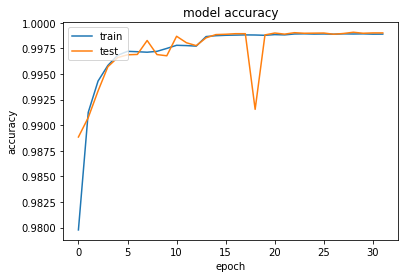

In [ ]:
# summarize history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

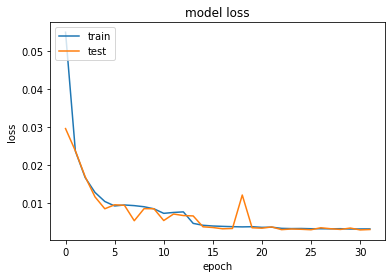

In [ ]:
# summarize history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(model.metrics_names)
model.evaluate(X_test, y_test_k, verbose=0)

['loss', 'accuracy']


[0.0033622928895056248, 0.9989520311355591]

In [ ]:
y_predict_prob = model.predict(X_test)

In [ ]:
y_predict = y_predict_prob.argmax(axis=-1)

In [36]:
from sklearn.metrics import confusion_matrix

In [ ]:
conf_mx = confusion_matrix(y_test, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[96612   114]
 [   59 68296]]


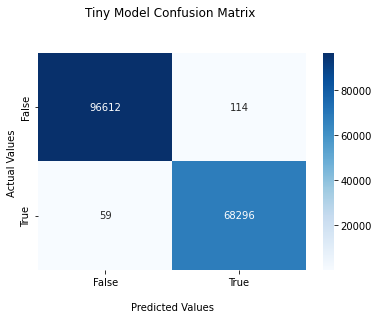

In [ ]:

ax = sns.heatmap(conf_mx, annot=True, cmap='Blues', fmt='g')

ax.set_title('Tiny Model Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Bluiding the Big model

In [ ]:
inputs = Input(shape=(68,1))

x1= bblock(inputs)
x= Reshape((68,1),input_shape=(1,68))(x1)
x = Concatenate()([x,inputs])
x2 = bblock(x)
x= Reshape((68,1),input_shape=(1,68))(x2)
x = Concatenate()([x,inputs])
x3= bblock(x)
x = Average()([x1,x2,x3])
#x= Dense(64,activation='relu')(x)
x= Dense(2,activation='sigmoid')(x)
bmodel = Model(inputs=inputs,outputs =x)

In [ ]:
bmodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 68, 1)]      0           []                               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 66, 128)      512         ['input_2[0][0]']                
                                                                                                  
 conv1d_12 (Conv1D)             (None, 66, 128)      512         ['input_2[0][0]']                
                                                                                                  
 conv1d_10 (Conv1D)             (None, 64, 68)       26180       ['conv1d_9[0][0]']               
                                                                                            

Training the Big model

In [ ]:
batchSize = 128
nEpochs = 32

with tf.device('/device:GPU:0'):    
  bmodel.compile(loss='categorical_crossentropy', 
                            optimizer='adam', 
                            metrics=['accuracy'])
  
  # saving best model weights
  checkpoint_filepath = '/content/drive/MyDrive/CV/btmp'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
  
  # change learing rate if the loss stop changing 
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)


  history2 = bmodel.fit(X_train, y_train_k, batch_size=batchSize, epochs=nEpochs, verbose=1,callbacks=[model_checkpoint_callback,reduce_lr],
                                  validation_data=(X_val, y_val_k))

Epoch 1/32
5159/5159 [==============================] - 210s 38ms/step - loss: 0.0472 - accuracy: 0.9828 - val_loss: 0.0204 - val_accuracy: 0.9928 - lr: 0.0010
Epoch 2/32
5159/5159 [==============================] - 196s 38ms/step - loss: 0.0194 - accuracy: 0.9932 - val_loss: 0.0244 - val_accuracy: 0.9929 - lr: 0.0010
Epoch 3/32
5159/5159 [==============================] - 195s 38ms/step - loss: 0.0162 - accuracy: 0.9944 - val_loss: 0.0076 - val_accuracy: 0.9983 - lr: 0.0010
Epoch 4/32
5159/5159 [==============================] - 197s 38ms/step - loss: 0.0126 - accuracy: 0.9961 - val_loss: 0.0098 - val_accuracy: 0.9967 - lr: 0.0010
Epoch 5/32
5159/5159 [==============================] - 195s 38ms/step - loss: 0.0107 - accuracy: 0.9967 - val_loss: 0.0063 - val_accuracy: 0.9982 - lr: 0.0010
Epoch 6/32
5159/5159 [==============================] - 198s 38ms/step - loss: 0.0102 - accuracy: 0.9969 - val_loss: 0.0106 - val_accuracy: 0.9970 - lr: 0.0010
Epoch 7/32
5159/5159 [==================

In [ ]:
bmodel.save_weights('/content/drive/MyDrive/CV/bigmodel/big')

In [ ]:
# Restore the weights
bmodel.load_weights('/content/drive/MyDrive/CV/bigmodel/big')

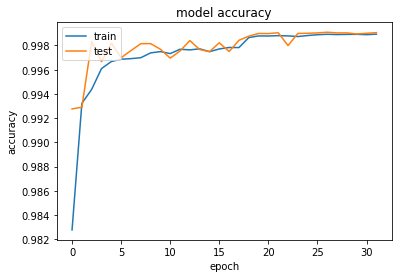

In [ ]:
# summarize history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


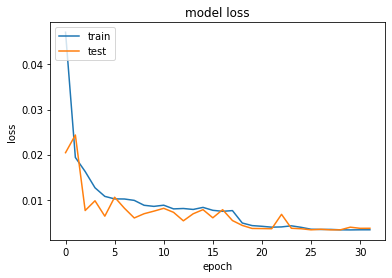

In [ ]:
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
print(bmodel.metrics_names)
bmodel.evaluate(X_test, y_test_k, verbose=0)

['loss', 'accuracy']


[0.0040162610821425915, 0.9989762306213379]

In [ ]:
y_predict_prob = bmodel.predict(X_test)

In [ ]:
y_predict = y_predict_prob.argmax(axis=-1)

In [38]:
conf_mx = confusion_matrix(y_test, y_predict)
print('Confusion matrix: \n{0}'.format(conf_mx))

Confusion matrix: 
[[96599   127]
 [   42 68313]]


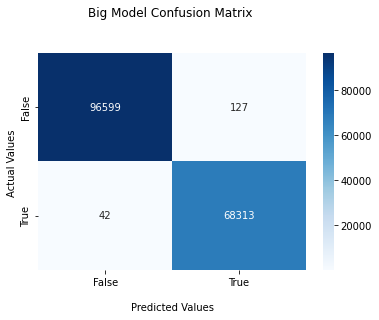

In [41]:
ax = sns.heatmap(conf_mx, annot=True, cmap='Blues', fmt='g')

ax.set_title('Big Model Confusion Matrix \n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()